In [3]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [4]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [35]:
foo = pd.read_csv('../data/TCGA/pilot_LUAD/gdc_sample_sheet.2019-12-09.tsv', sep="\t")
foo.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type
0,c5b283b8-a6ab-4652-b824-18fe1cebe0e3,0bf53fc6-b8fb-4e6d-9297-4129c708f3da.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-50-5935,TCGA-50-5935-01A,Primary Tumor
1,27079945-f3da-42b4-8c17-c82d66b7d321,f4a1e772-2a5e-4c0a-803a-1bdb2b376a47.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-55-6971,TCGA-55-6971-11A,Solid Tissue Normal
2,da368838-dad0-434d-a2a8-084b362e358e,12d2b9fa-1921-4033-bdb9-7e114c0d7812.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-99-8025,TCGA-99-8025-01A,Primary Tumor
3,be46ee72-8958-483f-bd54-38d21ebf7ff6,4d36e127-5fad-4b97-afff-28f4bdbf5f5d.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-55-8301,TCGA-55-8301-01A,Primary Tumor
4,c5f764bd-a9d4-4188-a4dc-a5e6ca1183f8,c57c5f57-5426-4662-832d-6f342ebeff04.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LUAD,TCGA-73-4677,TCGA-73-4677-01A,Primary Tumor


In [37]:
foo['Sample Type'].value_counts()

Primary Tumor          1599
Solid Tissue Normal     177
Recurrent Tumor           6
Name: Sample Type, dtype: int64

In [5]:
samples.shape
cases = samples[samples['Sample Type']=='Primary Tumor'].sample(frac=1).copy()
cases.shape
proj = cases['project'].value_counts().head(10).index
cases = cases[cases['project'].isin(proj)]
cases['project'].value_counts()
cases.shape

(9364, 10)

(8166, 10)

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
BLCA     412
Name: project, dtype: int64

(5432, 10)

## Dataset Prep

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'project'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

BRCA    820
UCEC    407
LUAD    400
LUSC    381
LGG     378
KIRC    356
COAD    355
PRAD    353
THCA    332
BLCA    292
Name: project, dtype: int64

BRCA    267
UCEC    137
LUAD    128
LGG     128
KIRC    127
BLCA    120
LUSC    115
THCA    113
PRAD    113
COAD    110
Name: project, dtype: int64

In [8]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'BLCA': 0,
 'BRCA': 1,
 'COAD': 2,
 'KIRC': 3,
 'LGG': 4,
 'LUAD': 5,
 'LUSC': 6,
 'PRAD': 7,
 'THCA': 8,
 'UCEC': 9}

In [9]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network

In [12]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 64
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 5

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=60483, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [13]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/4074 (0%)]	Loss: 0.248647
Train: [320/4074 (8%)]	Loss: 0.310211
Train: [640/4074 (16%)]	Loss: 0.124154
Train: [960/4074 (23%)]	Loss: 0.075968
Train: [1280/4074 (31%)]	Loss: 1.051746
Train: [1600/4074 (39%)]	Loss: 0.180839
Train: [1920/4074 (47%)]	Loss: 0.111274
Train: [2240/4074 (55%)]	Loss: 0.252777
Train: [2560/4074 (62%)]	Loss: 0.136673
Train: [2880/4074 (70%)]	Loss: 0.585527
Train: [3200/4074 (78%)]	Loss: 1.609950
Train: [3520/4074 (86%)]	Loss: 9.314102
Train: [3840/4074 (94%)]	Loss: 0.474410
Epoch: 1/20. Train set: Average loss: 1.1210
Epoch: 1/20. Validation set: Average loss: 0.2606
Train: [0/4074 (0%)]	Loss: 0.132143
Train: [320/4074 (8%)]	Loss: 0.206611
Train: [640/4074 (16%)]	Loss: 1.958800
Train: [960/4074 (23%)]	Loss: 2.033570
Train: [1280/4074 (31%)]	Loss: 0.376870
Train: [1600/4074 (39%)]	Loss: 0.935826
Train: [1920/4074 (47%)]	Loss: 0.256294
Train: [2240/4074 (55%)]	Loss: 1.929032
Train: [2560/4074 (62%)]	Loss: 0.913257
Train: [2880/4074 (70%)]	Loss: 0.221431
T

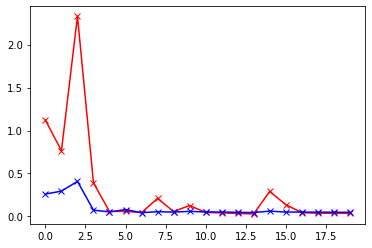

In [14]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

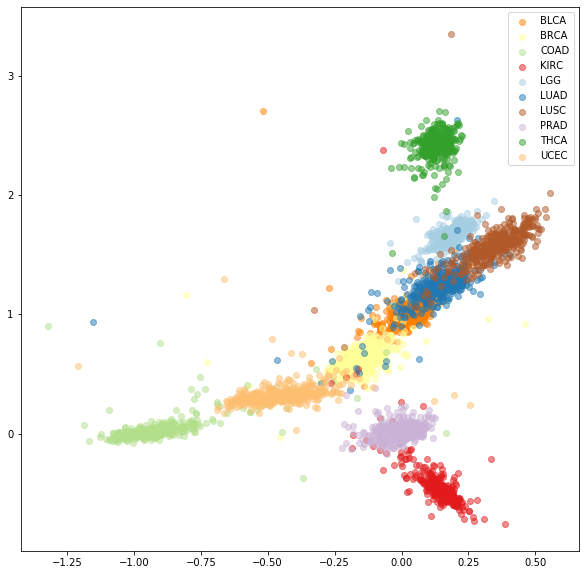

In [15]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

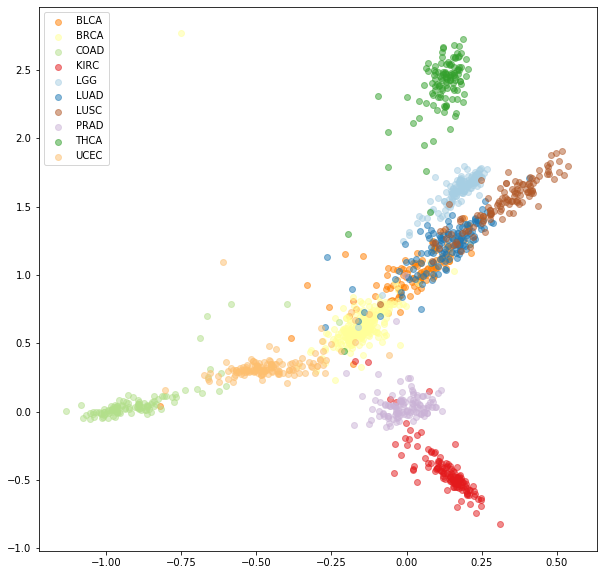

In [16]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)